In [1]:
import scanpy as sc
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch_geometric.data import Data
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

import sys, pathlib
repo_root = pathlib.Path('./st-celltype-deconvolution/src/models').resolve()
sys.path.insert(0, str(repo_root))

from vae_sc import VAE, vae_loss, compute_uncertainty
from uncertainty_gcn import UncertaintyGCN, compute_loss
from gcn_claude import ImprovedUncertaintyGCN, improved_loss

/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备:", device)

# ================== 1. 读取数据 ==================
scRNA = sc.read_h5ad("../scvi-tools-DestVI/data/sc_lymph_node_preprocessed.h5ad")
ST = sc.read_h5ad("../scvi-tools-DestVI/data/st_lymph_node_preprocessed.h5ad")
# 1. 构建GCN输入
# 假设ST_train为训练集，X_st为spot表达，E为参考表达谱
if "counts" in ST.layers:
    X_st = ST.layers["counts"]
else:
    X_st = ST.X

# 稀疏转稠密
if hasattr(X_st, "toarray"):
    X_st = X_st.toarray()
elif hasattr(X_st, "A"):  # 某些稀疏类型
    X_st = X_st.A

X_st = torch.tensor(X_st, dtype=torch.float32).to(device)
genes = scRNA.var_names.intersection(ST.var_names)
scRNA = scRNA[:, genes]

celltypes = scRNA.obs["cell_types"].astype("category").cat.categories.tolist()

使用设备: cuda


In [24]:
ST = ST[:, genes]

In [20]:
def train_vae_with_scheduling(vae, dataloader, num_epochs=100, device="cpu"):
    """带学习率调度和早停的VAE训练"""
    vae = vae.to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
    )
    
    best_loss = float('inf')
    patience = 15
    patience_counter = 0
    
    # 逐步增加KL权重
    beta_start, beta_end = 0.0001, 0.01
    beta_schedule = np.linspace(beta_start, beta_end, num_epochs//2)
    
    for epoch in range(num_epochs):
        vae.train()
        epoch_loss = 0
        
        # 设置当前beta值
        beta = beta_end if epoch >= len(beta_schedule) else beta_schedule[epoch]
        
        for x_batch, _ in dataloader:
            x_batch = x_batch.to(device)
            optimizer.zero_grad()
            
            dec_mu, dec_theta, dec_pi, mu, logvar = vae(x_batch)
            loss, zinb, kl = vae_loss(x_batch, dec_mu, dec_theta, dec_pi, mu, logvar, beta=beta)
            
            loss.backward()
            # 梯度裁剪防止爆炸
            torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Beta: {beta:.6f}")
        
        # 验证并调整学习率
        scheduler.step(avg_loss)
        
        # 早停
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            # 保存最佳模型
            torch.save(vae.state_dict(), "best_vae_model.pt")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
                
    # 加载最佳模型
    vae.load_state_dict(torch.load("best_vae_model.pt"))
    return vae

/tmp/ipykernel_2630179/894040462.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_st = torch.tensor(X_st, dtype=torch.float32).to(device)


Epoch 1/100, Loss: 0.4671, Beta: 0.000100
Epoch 2/100, Loss: 0.4306, Beta: 0.000302
Epoch 3/100, Loss: 0.4246, Beta: 0.000504
Epoch 4/100, Loss: 0.4207, Beta: 0.000706
Epoch 5/100, Loss: 0.4190, Beta: 0.000908
Epoch 6/100, Loss: 0.4173, Beta: 0.001110
Epoch 7/100, Loss: 0.4158, Beta: 0.001312
Epoch 8/100, Loss: 0.4181, Beta: 0.001514
Epoch 9/100, Loss: 0.4174, Beta: 0.001716
Epoch 10/100, Loss: 0.4143, Beta: 0.001918
Epoch 11/100, Loss: 0.4144, Beta: 0.002120
Epoch 12/100, Loss: 0.4141, Beta: 0.002322
Epoch 13/100, Loss: 0.4135, Beta: 0.002524
Epoch 14/100, Loss: 0.4129, Beta: 0.002727
Epoch 15/100, Loss: 0.4129, Beta: 0.002929
Epoch 16/100, Loss: 0.4137, Beta: 0.003131
Epoch 17/100, Loss: 0.4131, Beta: 0.003333
Epoch 18/100, Loss: 0.4123, Beta: 0.003535
Epoch 19/100, Loss: 0.4127, Beta: 0.003737
Epoch 20/100, Loss: 0.4136, Beta: 0.003939
Epoch 21/100, Loss: 0.4139, Beta: 0.004141
Epoch 22/100, Loss: 0.4127, Beta: 0.004343
Epoch 23/100, Loss: 0.4117, Beta: 0.004545
Epoch 24/100, Loss: 

/tmp/ipykernel_2630179/894040462.py:75: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2630179/894040462.py:75: UserWarning: Glyph 31181 (\N{CJK UNIFIED IDEOGRAPH-79CD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2630179/894040462.py:75: UserWarning: Glyph 32454 (\N{CJK UNIFIED IDEOGRAPH-7EC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2630179/894040462.py:75: UserWarning: Glyph 32990 (\N{CJK UNIFIED IDEOGRAPH-80DE}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2630179/894040462.py:75: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2630179/894040462.py:75: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_2630179/894040462.py:75: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.

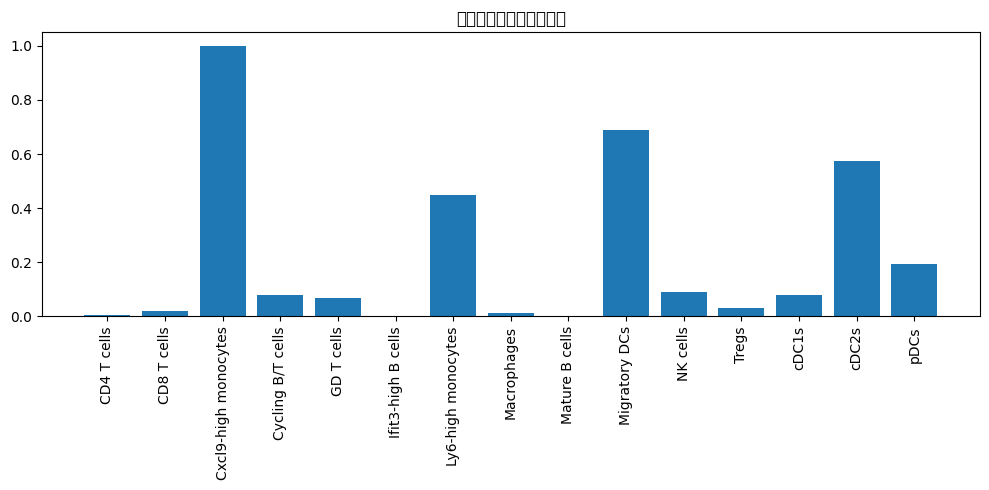

In [23]:
# 准备数据
if "counts" in scRNA.layers:
    X_sc = scRNA.layers["counts"]
else:
    X_sc = scRNA.X

# 稀疏转稠密
if hasattr(X_sc, "toarray"):
    X_sc = X_sc.toarray()
elif hasattr(X_sc, "A"):  # 某些稀疏类型
    X_sc = X_sc.A

X_st = torch.tensor(X_st, dtype=torch.float32).to(device)
# X_sc = scRNA.X.A if hasattr(scRNA.X, "A") else scRNA.X
X_sc = torch.tensor(X_sc, dtype=torch.float32)
labels = scRNA.obs["cell_types"].astype("category").cat.codes.values
labels = torch.tensor(labels, dtype=torch.long)

dataset = TensorDataset(X_sc, labels)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 初始化VAE模型
n_genes = X_sc.shape[1]
hidden_dims = [512, 256]
latent_dim = 32
vae = VAE(input_dim=n_genes, hidden_dims=hidden_dims, latent_dim=latent_dim).to(device)

# 训练VAE（使用优化的训练函数）
vae = train_vae_with_scheduling(
    vae=vae,
    dataloader=dataloader,
    num_epochs=100,  # 可根据需要调整
    device=device
)

# 也可以用更简单的训练循环
"""
epochs = 50
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
for epoch in range(1, epochs+1):
    vae.train()
    sum_loss = sum_recon = sum_kl = 0.0
    for x_batch, _ in dataloader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x_batch)
        loss, recon, kl = vae_loss(x_batch, x_hat, mu, logvar, beta=1e-3)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
        sum_recon += recon.item()
        sum_kl += kl.item()

    if epoch % 10 == 0:
        print(f"VAE Epoch {epoch}/{epochs}, loss={sum_loss:.2f}, recon={sum_recon:.2f}, kl={sum_kl:.2f}")
"""

# 计算细胞类型不确定性
n_types = len(celltypes)
sc_loader_for_unc = DataLoader(dataset, batch_size=256, shuffle=False)
RE, KL, VAR, RE_c, KL_c, VAR_c = compute_uncertainty(
    vae, sc_loader_for_unc, device=device, n_types=n_types, fill_value=0.0
)

# 归一化细胞类型不确定性作为GCN的输入
type_unc = (RE_c - RE_c.min()) / (RE_c.max() - RE_c.min() + 1e-8)
print("细胞类型不确定性:", type_unc)

# 可视化不确定性
plt.figure(figsize=(10, 5))
plt.bar(range(len(type_unc)), type_unc)
plt.xticks(range(len(type_unc)), celltypes, rotation=90)
plt.title("每种细胞类型的不确定性")
plt.tight_layout()
plt.show()

vae训练完毕，得到细胞类型水平的不确定性

In [25]:
import numpy as np
import pandas as pd

def get_reference_profile(sc_adata, celltype_key="cell_types"):
    """
    计算每个细胞类型的参考表达谱（均值表达），返回 shape: [n_types, n_genes]
    """
    celltypes = sc_adata.obs[celltype_key].astype("category").cat.categories
    expr = []
    for ct in celltypes:
        idx = (sc_adata.obs[celltype_key] == ct)
        # 取原始计数或你需要的表达矩阵
        X = sc_adata[idx].layers["counts"] if "counts" in sc_adata.layers else sc_adata[idx].X
        X = X.A if hasattr(X, "A") else X
        expr.append(np.asarray(X).mean(axis=0))
    expr = np.stack(expr, axis=0)  # shape: [n_types, n_genes]
    return expr, list(celltypes), list(sc_adata.var_names)

# 用法
E, ref_celltypes, ref_genes = get_reference_profile(scRNA, celltype_key="cell_types")
print(E.shape)  # (n_types, n_genes)

(15, 1888)


In [26]:


# 2. 构建空间邻接关系（edge_index），假设ST_train有空间坐标
coords = ST.obsm["spatial"]  # shape: [n_spots, 2]
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=6).fit(coords)
edges = nbrs.kneighbors_graph(coords).tocoo()
edge_index = np.vstack([edges.row, edges.col])
edge_index = torch.tensor(edge_index, dtype=torch.long).to(device)

# 3. 初始化GCN模型
n_types = len(celltypes)
gcn = ImprovedUncertaintyGCN(
    in_dim=X_st.shape[1],
    hidden_dim=128,
    n_types=n_types,
    type_uncertainty=type_unc,
    dropout=0.2
).to(device)

# 4. 训练GCN
optimizer = torch.optim.Adam(gcn.parameters(), lr=1e-3, weight_decay=1e-5)
epochs = 500
# E = ... # 你的参考表达谱（shape: n_types, n_genes），需提前准备好

for epoch in range(epochs):
    gcn.train()
    optimizer.zero_grad()
    # 前向传播
    pred = gcn(X_st, edge_index)  # pred: [n_spots, n_types]
    loss = improved_loss(pred[0], X_st, E, edge_index, type_unc)
    if isinstance(loss, tuple):
        loss = loss[0]
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"GCN Epoch {epoch+1}/{epochs}, loss={loss.item():.4f}")

# 5. pred 即为每个spot的细胞类型分数，可softmax归一化为比例

GCN Epoch 10/500, loss=33.2033
GCN Epoch 20/500, loss=28.8720
GCN Epoch 30/500, loss=27.1355
GCN Epoch 40/500, loss=25.7673
GCN Epoch 50/500, loss=24.8553
GCN Epoch 60/500, loss=24.9654
GCN Epoch 70/500, loss=23.9784
GCN Epoch 80/500, loss=23.6594
GCN Epoch 90/500, loss=23.4787
GCN Epoch 100/500, loss=23.2293
GCN Epoch 110/500, loss=22.7978
GCN Epoch 120/500, loss=23.0482
GCN Epoch 130/500, loss=22.7536
GCN Epoch 140/500, loss=22.6174
GCN Epoch 150/500, loss=22.5357
GCN Epoch 160/500, loss=22.4078
GCN Epoch 170/500, loss=22.5330
GCN Epoch 180/500, loss=22.1972
GCN Epoch 190/500, loss=22.2317
GCN Epoch 200/500, loss=22.0771
GCN Epoch 210/500, loss=22.1656
GCN Epoch 220/500, loss=22.1395
GCN Epoch 230/500, loss=22.1547
GCN Epoch 240/500, loss=22.0491
GCN Epoch 250/500, loss=21.8734
GCN Epoch 260/500, loss=21.9633
GCN Epoch 270/500, loss=22.0038
GCN Epoch 280/500, loss=21.8326
GCN Epoch 290/500, loss=21.7058
GCN Epoch 300/500, loss=21.7419
GCN Epoch 310/500, loss=21.7167
GCN Epoch 320/500

In [27]:
# 1. GCN推断，得到每个spot的细胞类型分数
gcn.eval()
with torch.no_grad():
    pred = gcn(X_st, edge_index)  # [n_spots, n_types]
    pred = pred[0]

# 2. 用参考表达谱重建spot表达
E_tensor = torch.tensor(E, dtype=torch.float32, device=pred.device)  # [n_types, n_genes]
X_recon = pred @ E_tensor  # [n_spots, n_genes]

# 3. 计算R²
from sklearn.metrics import r2_score
X_true = X_st.cpu().numpy()
X_pred = X_recon.cpu().numpy()
r2 = r2_score(X_true.reshape(-1), X_pred.reshape(-1))
print(f"GCN重建表达的R²: {r2:.4f}")

GCN重建表达的R²: 0.6058


In [29]:
print(coords.shape)
print(coords[:5])

(1092, 2)
[[-1785.  3553.]
 [-1022.  2791.]
 [ -696.  1587.]
 [-1655.   853.]
 [ -677.  2786.]]


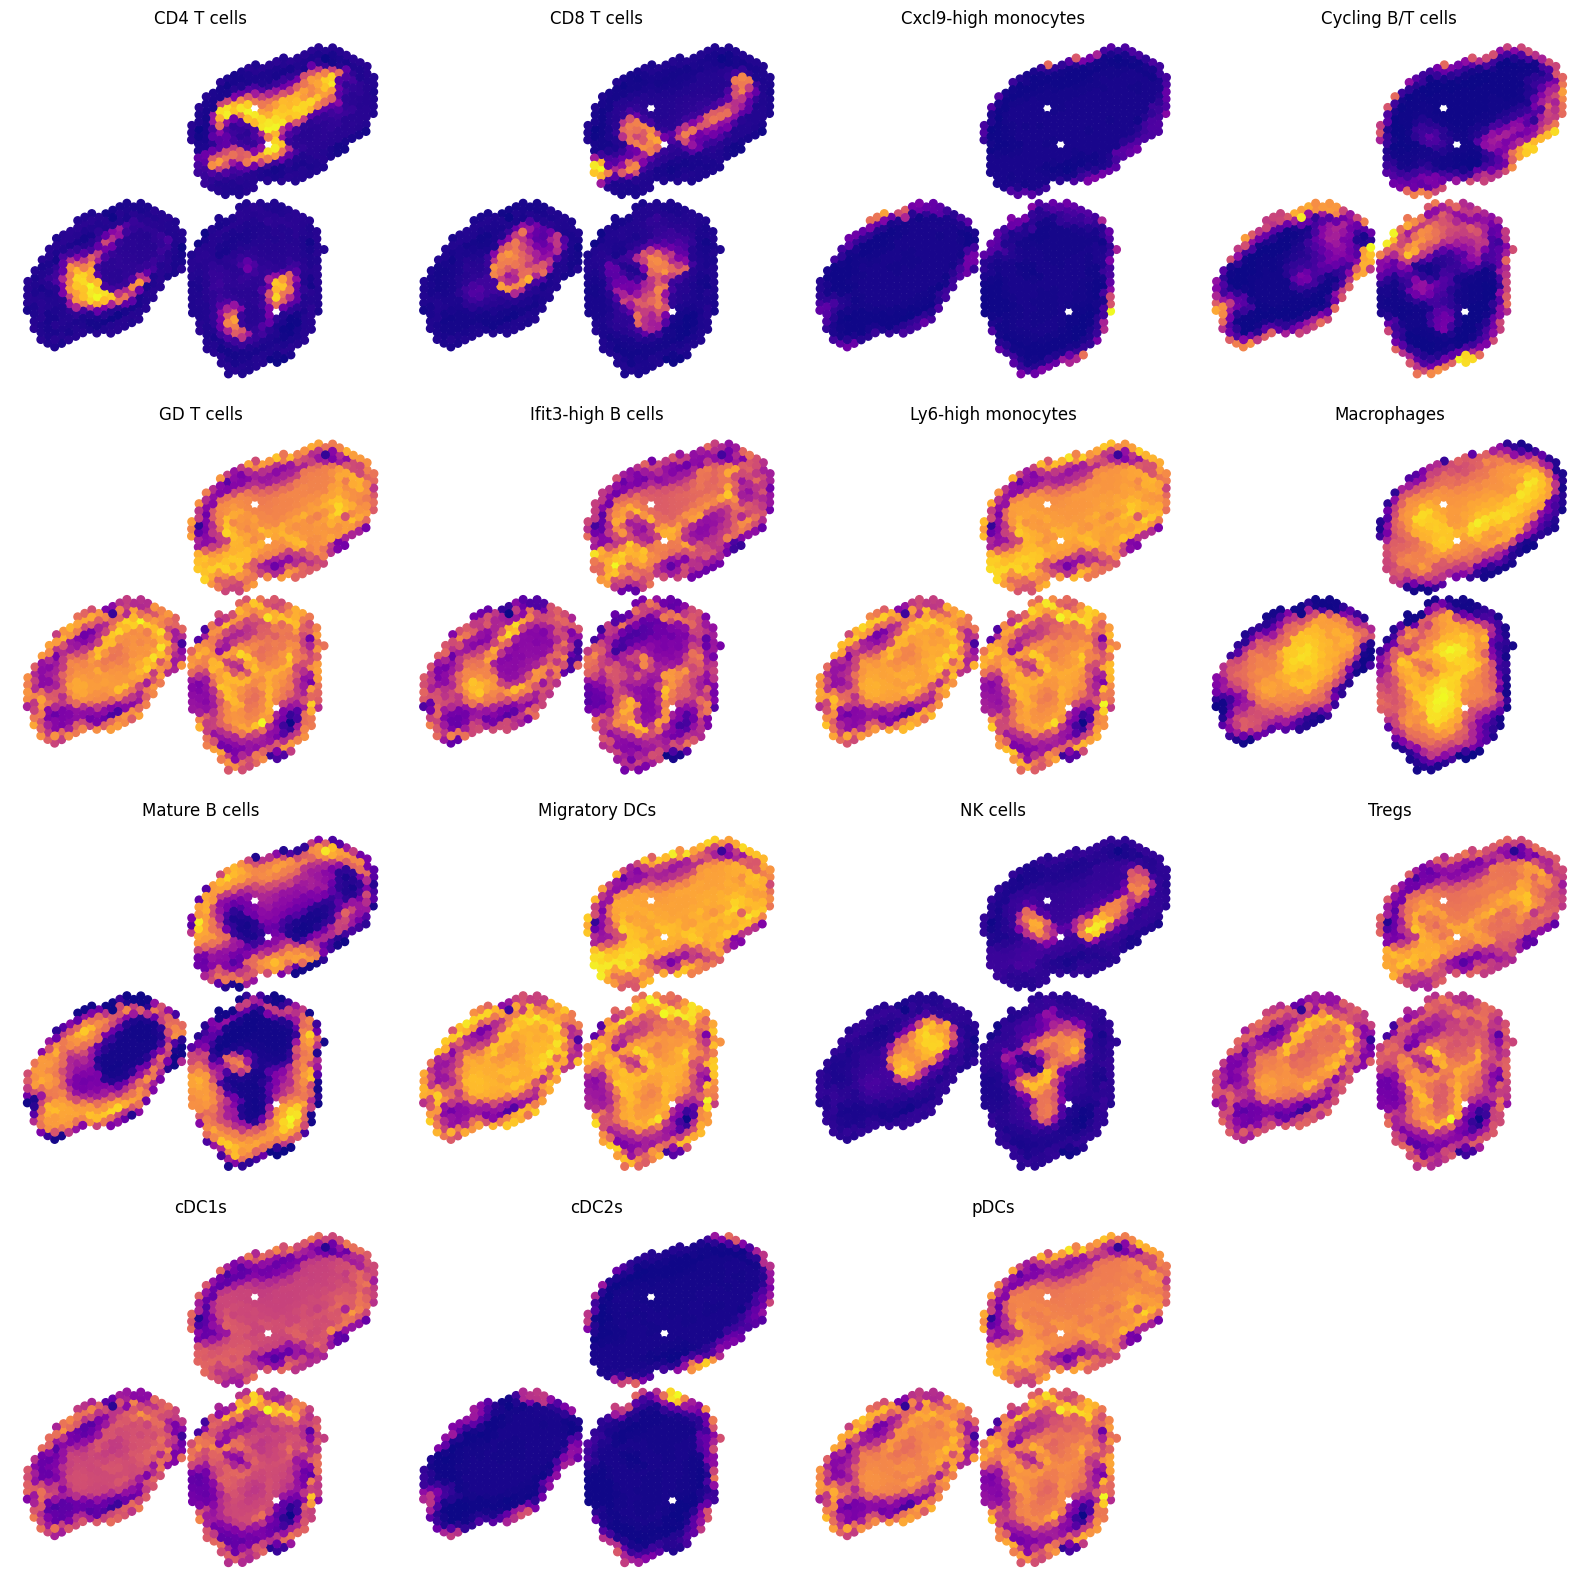

In [30]:
import math

n_types = len(celltypes)
n_cols = 4
n_rows = math.ceil(n_types / n_cols)

plt.figure(figsize=(4 * n_cols, 4 * n_rows))
for i, ct in enumerate(celltypes):
    plt.subplot(n_rows, n_cols, i+1)
    # 交换coords的顺序，并翻转y轴
    plt.scatter(coords[:, 1], coords[:, 0], c=pred[:, i], s=30, cmap='plasma')
    plt.title(ct)
    plt.axis('off')
    plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20027 (\N{CJK UNIFIED IDEOGRAPH-4E3B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32454 (\N{CJK UNIFIED IDEOGRAPH-7EC6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32990 (\N{CJK UNIFIED IDEOGRAPH-80DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/pxy/miniconda3/envs/tangram-env/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: Us

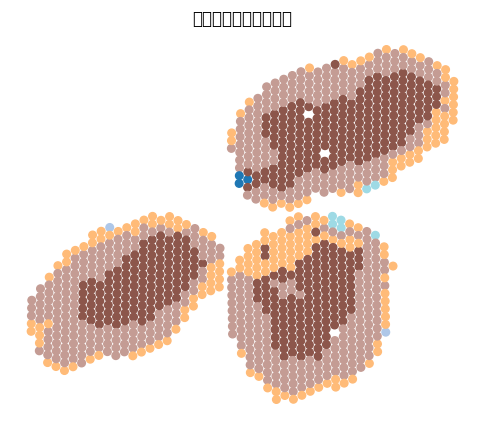

In [31]:
main_type = np.argmax(pred, axis=1)
plt.figure(figsize=(6, 5))
plt.scatter(coords[:, 1], coords[:, 0], c=main_type, s=30, cmap='tab20')
plt.title("主导细胞类型空间分布")
plt.axis('off')
plt.gca().invert_yaxis()
plt.show()